# Convolutional Neural Network

__Project Description:__ <br>
This notebook contains exploratory data analysis and the convolutional neural network model used to predict whether or not a location is susceptible to wildfires.  The data for this exploration consists of roughly 20,000 labeled satellite images. 10,000 of the images are locations which have experienced wildfires, while the other 10,000 have never seen a wildfire before.  <br>Examples below: 

While I was unable to collect satellite imagery of the site a few days before the fire, I believe this will suffice as a proof of concept, especially since areas that experience wildfires often experience them again.

# Importing Libraries:

In [1]:
import pandas as pd
import numpy as np

# Plots and Graphs
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import scikitplot as skplt
import folium 
%matplotlib inline

import requests
import random
from IPython.display import Image, display

# API and Requests
import urllib.request

# Keras/Tensorflow
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau

# Shows all columns
pd.set_option('display.max_columns', None)

# Turning off warnings
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


# Importing Data:

Source: [here](https://geo.wa.gov/datasets/wadnr::dnr-fire-statistics-2008-present-1/data?geometry=-126.579%2C45.325%2C-111.143%2C47.964&orderBy=FIRE_RGE_WHOLE_NO&orderByAsc=false&selectedAttribute=ACRES_BURNED)

In [2]:
df = pd.read_csv('DNR_Fire_Statistics_2008_-_Present.csv')
df = df.sample(frac=1).reset_index(drop=True) # Shuffling the data
df.head()

,X,Y,OBJECTID,FIREEVENT_ID,INCIDENT_NO,INCIDENT_NM,INCIDENT_ID,COUNTY_LABEL_NM,FIRE_TWP_WHOLE_NO,FIRE_TWP_FRACT_NO,FIRE_RGE_WHOLE_NO,FIRE_RGE_FRACT_NO,FIRE_RGE_DIR_FLG,FIRE_SECT_NO,SITE_ELEV,FIREGCAUSE_LABEL_NM,FIRESCAUSE_LABEL_NM,BURNESCAPE_RSN_LABEL_NM,ACRES_BURNED,START_DT,START_TM,DSCVR_DT,DSCVR_TM,CONTROL_DT,CONTROL_TM,FIRE_OUT_DT,FIRE_OUT_TM,BURN_MERCH_AREA,BURN_REPROD_AREA,BURN_NONSTOCK_AREA,FIREEVNT_CLASS_CD,FIREEVNT_CLASS_LABEL_NM,SECTION_SUBDIV_PTS_ID,LAT_COORD,LON_COORD,RES_ORDER_NO,NON_DNR_RES_ORDER_NO,START_OWNER_AGENCY_NM,START_JURISDICTION_AGENCY_NM,PROTECTION_TYPE,REGION_NAME
0,-1.364630e+07,5.773948e+06,17619,59586,49,LEWIS RIVER,59439,COWLITZ,6,0,3,0,E,24,450.0,Debris Burn,None,High Winds,0.90,2019/04/29 08:00:00+00,1400,1970/01/01 00:00:00+00,NaN,2019/04/30 00:00:00+00,1218.0,2019/05/01 00:00:00+00,1602.0,NaN,NaN,NaN,1,Classified,77803,45.960028,-122.586795,WA-PCS-0075,NaN,Private,DNR,DNR Protection FFPA,PACIFIC CASC
1,-1.369961e+07,5.983186e+06,2656,29737,55,POWERLINE,29357,MASON,20,0,3,0,W,4,218.0,Undetermined,None,NaN,9.30,2012/09/26 08:00:00+00,1439,2012/09/26 00:00:00+00,1500.0,2012/09/26 00:00:00+00,2205.0,2012/10/31 00:00:00+00,1200.0,NaN,6.3,3.0,1,Classified,121125,47.251274,-123.065633,WA-SPS-0055,NaN,Private,DNR,DNR Protection FFPA,SO PUGET
2,-1.361797e+07,6.225497e+06,5589,15805,21,Gooseberry,15947,WHATCOM,37,0,4,0,E,8,520.0,Children,Children 10+,NaN,0.10,2010/08/17 08:00:00+00,1900,2010/08/17 00:00:00+00,1900.0,2010/08/18 00:00:00+00,1100.0,2010/08/25 00:00:00+00,1735.0,NaN,NaN,NaN,1,Classified,1091423,48.708210,-122.332310,WA-NWS-021,NaN,Private,DNR,DNR Protection FFPA,NORTHWEST
3,-1.330234e+07,6.188931e+06,11444,59843,71,RIVERSIDE SHOULDER,59696,OKANOGAN,35,0,26,0,E,36,NaN,Undetermined,None,NaN,0.71,2019/05/03 08:00:00+00,1719,1970/01/01 00:00:00+00,NaN,1970/01/01 00:00:00+00,NaN,1970/01/01 00:00:00+00,NaN,NaN,NaN,NaN,1,Classified,742035,48.490990,-119.496990,NaN,NaN,NaN,WA Fire Service,DNR Assist Other Agency,NORTHEAST
4,-1.311632e+07,6.000496e+06,5823,29667,262,FISH RESORT,29288,LINCOLN,22,0,39,0,E,36,2107.0,Arson,Pyromaniac,NaN,0.87,2012/09/04 08:00:00+00,135,2012/09/04 00:00:00+00,900.0,2012/09/04 00:00:00+00,1145.0,2012/10/17 00:00:00+00,1200.0,NaN,NaN,NaN,1,Classified,655717,47.356710,-117.825910,NaN,WA-SPD-909,Bureau Of Land Management,Bureau Of Land Management,DNR Protection FFPA,NORTHEAST


## Column Descriptions:

__Column:__

- __X:__                            
- __Y:__                              
- __OBJECTID:__ Unique ID
- __FIREEVENT_ID:__ Unique ID
- __INCIDENT_NO:__ Incident Number
- __INCIDENT_NM:__ Incident Name (trail or forest area)
- __INCIDENT_ID:__ 
- __COUNTY_LABEL_NM:__ County Name (King, Stevens, etc. . .)          
- __FIRE_TWP_WHOLE_NO:__ 
- __FIRE_TWP_FRACT_NO:__
- __FIRE_RGE_WHOLE_NO:__
- __FIRE_RGE_FRACT_NO:__
- __FIRE_RGE_DIR_FLG:__
- __FIRE_SECT_NO:__
- __SITE_ELEV:__ Elevation of site
- __FIREGCAUSE_LABEL_NM:__ Cause
- __FIRESCAUSE_LABEL_NM:__ Secondary cause
- __BURNESCAPE_RSN_LABEL_NM:__
- __ACRES_BURNED:__ Acres Burned
- __START_DT:__ Start Date
- __START_TM:__ Start Time
- __DSCVR_DT:__ Discovery Date
- __DSCVR_TM:__ Discovery Time
- __CONTROL_DT:__ Date brought under control
- __CONTROL_TM:__ Time brought under control
- __FIRE_OUT_DT:__ Date fire was put out
- __FIRE_OUT_TM:__ Time fire was put out
- __BURN_MERCH_AREA:__
- __BURN_REPROD_AREA:__
- __BURN_NONSTOCK_AREA:__
- __FIREEVNT_CLASS_CD:__
- __FIREEVNT_CLASS_LABEL_NM:__ 'Classified' or 'Other Agency'
- __SECTION_SUBDIV_PTS_ID:__ 
- __LAT_COORD:__ Longitude
- __LON_COORD:__ Latitude
- __RES_ORDER_NO:__  
- __NON_DNR_RES_ORDER_NO:__ 
- __START_OWNER_AGENCY_NM:__ Owner of land where fire started (private, government, DNR, etc. . .)
- __START_JURISDICTION_AGENCY_NM:__ Jurisdiction where it started
- __PROTECTION_TYPE:__ Type of Protection of area
- __REGION_NAME:__  Region

## Images:

### Wildfire Area Image Previews:

__Image examples:__<br>
__Areas with wildfires:__
![text](example_images/wf1.jpg)
![text](example_images/wf2.jpg)
![text](example_images/wf3.jpg)

### Non-Wildfire Area Image Previews:

__Areas without wildfires:__
![text](example_images/nwf1.jpg)
![text](example_images/nwf2.jpg)
![text](example_images/nwf3.jpg)

# Cleaning:

In [3]:
# Quick spelling error fixed
df['FIREGCAUSE_LABEL_NM'] = df['FIREGCAUSE_LABEL_NM'].map(lambda x: 'Misc' 
                                                          if x == 'Miscellaneou' 
                                                          else x)

In [4]:
# Dealing with dates: 
df['date'] = pd.to_datetime(df.START_DT)
df.date = df.date.dt.strftime('%m/%d/%Y')
df['date'] = pd.to_datetime(df.date)
# Extracting Month
df['month'] = pd.DatetimeIndex(df['date']).month
df['year'] = pd.DatetimeIndex(df['date']).year

# Exploratory Data Analysis:

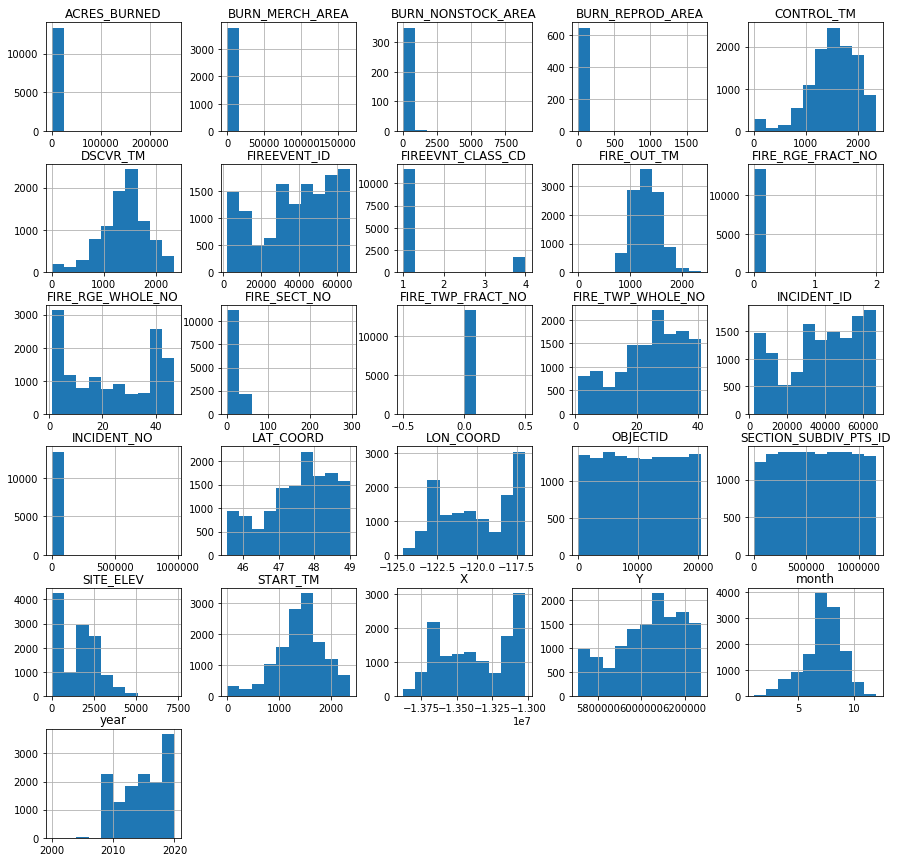

In [5]:
# Initial Histogram Plot
df.hist(figsize=(15,15));

## Bar Chart by Region: 

In [6]:
# Unique Regions:
print('Regions of Fires:\n\n', df.REGION_NAME.value_counts())

Regions of Fires:

 NORTHEAST       6447
SOUTHEAST       2557
PACIFIC CASC    1661
SO PUGET        1482
NORTHWEST        791
OLYMPIC          441
Name: REGION_NAME, dtype: int64


## Bar Chart by County:

In [7]:
print('Top 10 County of Fires:\n\n', df.COUNTY_LABEL_NM.value_counts()[:10])

Top 10 County of Fires:

 SPOKANE         2057
STEVENS         1782
OKANOGAN        1471
KLICKITAT        722
MASON            573
KITTITAS         565
THURSTON         559
CHELAN           485
FERRY            470
PEND OREILLE     467
Name: COUNTY_LABEL_NM, dtype: int64


## Elevation Histogram:

In [8]:
print('Minimum Elevation: ', min(df.SITE_ELEV))
print('Maximum Elevation: ', max(df.SITE_ELEV))

Minimum Elevation:  0.0
Maximum Elevation:  7287.0


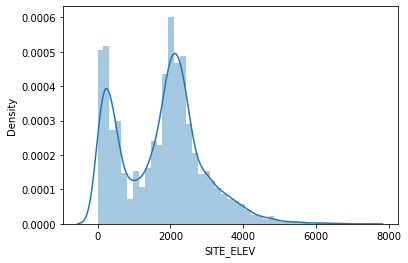

In [9]:
# Histogram of elevation for wildfires
# Most likely due to being clustered around two main sites. . . 
# I'd be interested to see where the high elevation fires are happening. . . 
# Especially the 8000 ft one!
dftest = df[df['SITE_ELEV'] > 0]
sns.distplot(dftest.SITE_ELEV);

## Map with Pins, Size by Acres:

In [10]:
print('Minimum Acres Burned: ', min(df.ACRES_BURNED))
print('Maximum Acres Burned: ', max(df.ACRES_BURNED))
# Change to > 0

Minimum Acres Burned:  0.0
Maximum Acres Burned:  250280.45


__Acre Histograms:__

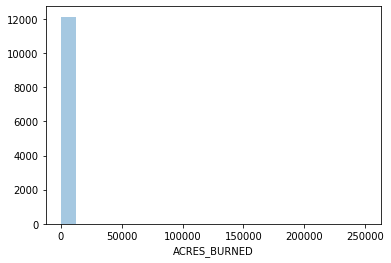

In [79]:
# Histogram of acres burned
# Mainly very small fires
# Heavy skew
dftest = df[df['ACRES_BURNED'] > 0]
sns.distplot(dftest.ACRES_BURNED, bins = 20, kde = False);

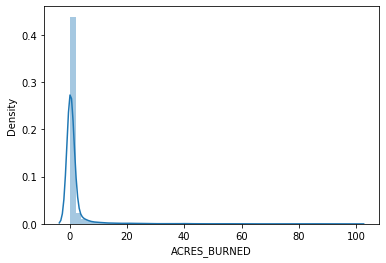

In [11]:
# Histogram of acres burned
# Mainly very small fires
dftest = df[df['ACRES_BURNED'] > 0]
dftest = dftest[dftest['ACRES_BURNED'] < 100]
sns.distplot(dftest.ACRES_BURNED);

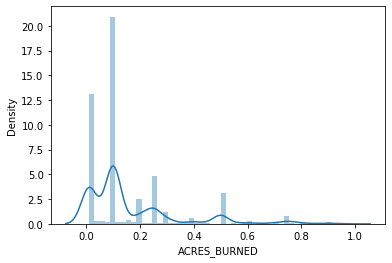

In [12]:
# Zooming in on fires under 1 acre
dftest = df[df['ACRES_BURNED'] > 0]
dftest = dftest[dftest['ACRES_BURNED'] < 1]
sns.distplot(dftest.ACRES_BURNED);

In [13]:
# Maybe also try pins with small, med, and large as separate pin colors
wa_coord = (47.4, -120.7401)
# Creating an empty map
map = folium.Map(location = wa_coord, zoom_start = 7.3, tiles='Cartodb Positron')

# Adding markers:
from folium.plugins import HeatMap
HeatMap(data=df[['LAT_COORD', 'LON_COORD', 'ACRES_BURNED']].\
        groupby(['LAT_COORD', 'LON_COORD']).sum().reset_index().\
        values.tolist(), radius=11).add_to(map)

display(map)

In [69]:
df_small = df[df['ACRES_BURNED'] > 0]
df_small = df_small[df_small['ACRES_BURNED'] < 10]
df_med = df[df['ACRES_BURNED'] >= 10]
df_med = df_med[df_med['ACRES_BURNED'] < 500]
df_large = df[df['ACRES_BURNED'] >= 500]

df_small = df_small[:150]
df_med = df_med[:150]
df_large = df_large[:150]

In [70]:
wa_coord = (47.4, -120.7401)
# Creating an empty map
map = folium.Map(location = wa_coord, zoom_start = 7.3, tiles='Cartodb Positron')

# Adding markers:
# Small - Yellow
for i in range(0,len(df_small)):
    folium.CircleMarker([df_small.iloc[i]['LAT_COORD'], 
                         df_small.iloc[i]['LON_COORD']],
                         radius = 3,
                         color= 'yellow',
                         fill_color='white',
                         popup=df_lightning.iloc[i]['ACRES_BURNED']).add_to(map)
    
# Med - Orange    
for i in range(0,len(df_med)):
    folium.CircleMarker([df_med.iloc[i]['LAT_COORD'], 
                         df_med.iloc[i]['LON_COORD']],
                         radius = 3,
                         color= 'orange',
                         fill_color='white',
                         popup=df_arson.iloc[i]['ACRES_BURNED']).add_to(map)
# Large - Red    
for i in range(0,len(df_large)):
    folium.CircleMarker([df_large.iloc[i]['LAT_COORD'], 
                         df_large.iloc[i]['LON_COORD']],
                         radius = 3,
                         color= 'red',
                         fill_color='white',
                         popup=df_eda.iloc[i]['ACRES_BURNED']).add_to(map)
display(map)

## Map with Pins, Color by Date: 

In [14]:
print('Earliest Start Date: ', min(df.START_DT))
print('Latest Start Date: ', max(df.START_DT))

Earliest Start Date:  2000/07/21 08:00:00+00
Latest Start Date:  2020/09/23 08:00:00+00


In [15]:
# Most fires happening in July/Aug - no surprise
df.month.value_counts()

7     3978
8     3443
9     1745
6     1629
5      924
4      655
10     561
3      288
11      80
2       45
1       16
12      15
Name: month, dtype: int64

In [47]:
df_jul = df[df['month'] == 7]
df_aug = df[df['month'] == 8]
df_sept = df[df['month'] ==  9]
#df_other = df[df['month'] ==  [7,8,9]]
# Limiting Sample
df_jul = df_jul[:150]
df_aug = df_aug[:150]
df_sept = df_sept[:150]
#df_other = df_other[:150]

In [48]:
wa_coord = (47.4, -120.7401)
# Creating an empty map
map = folium.Map(location = wa_coord, zoom_start = 7.3, tiles='Cartodb Positron')

# df_jul
# df_aug
# df_sept
# Adding markers:
# July - Yellow
for i in range(0,len(df_jul)):
    folium.CircleMarker([df_jul.iloc[i]['LAT_COORD'], 
                         df_jul.iloc[i]['LON_COORD']],
                         radius = 3,
                         color= 'yellow',
                         fill_color='white',
                         popup=df_lightning.iloc[i]['month']).add_to(map)
    
# Aug - Orange    
for i in range(0,len(df_aug)):
    folium.CircleMarker([df_aug.iloc[i]['LAT_COORD'], 
                         df_aug.iloc[i]['LON_COORD']],
                         radius = 3,
                         color= 'orange',
                         fill_color='white',
                         popup=df_arson.iloc[i]['month']).add_to(map)
# Sept - Red    
for i in range(0,len(df_sept)):
    folium.CircleMarker([df_sept.iloc[i]['LAT_COORD'], 
                         df_sept.iloc[i]['LON_COORD']],
                         radius = 3,
                         color= 'red',
                         fill_color='white',
                         popup=df_eda.iloc[i]['month']).add_to(map)
display(map)

## Map with Pins, Color by Cause:

In [17]:
print('Cause of Fires:\n\n',df.FIREGCAUSE_LABEL_NM.value_counts())

Cause of Fires:

 Misc            3354
Lightning       2624
Debris Burn     2266
Recreation      2001
Undetermined    1392
Under Invest     569
Arson            407
Children         334
Smoker           221
Logging          134
Railroad          77
Name: FIREGCAUSE_LABEL_NM, dtype: int64


In [33]:
df_lightning = df[df['FIREGCAUSE_LABEL_NM'] == 'Lightning']
df_arson = df[df['FIREGCAUSE_LABEL_NM'] == 'Arson']
df_debris = df[df['FIREGCAUSE_LABEL_NM'] == 'Debris Burn']
# Limiting Sample
df_lightning = df_lightning[:150]
df_arson = df_arson[:150]
df_debris = df_debris[:150]
###
df100 = df[:150]

In [37]:
# Folium with Markers
# Idea: Change to arson vs not arson
# add legend
# Shuffle data!!
# Add Lightnight


wa_coord = (47.4, -120.7401)
# Creating an empty map
map = folium.Map(location = wa_coord, zoom_start = 7.3, tiles='Cartodb Positron')

# Lightning - Yellow
for i in range(0,len(df_lightning)):
    folium.CircleMarker([df_lightning.iloc[i]['LAT_COORD'], 
                         df_lightning.iloc[i]['LON_COORD']],
                         radius = 3,
                         color= 'yellow',
                         fill_color='white',
                         popup=df_lightning.iloc[i]['FIREGCAUSE_LABEL_NM']).add_to(map)
    
# Arson - Red    
for i in range(0,len(df_arson)):
    folium.CircleMarker([df_arson.iloc[i]['LAT_COORD'], 
                         df_arson.iloc[i]['LON_COORD']],
                         radius = 3,
                         color= 'red',
                         fill_color='white',
                         popup=df_arson.iloc[i]['FIREGCAUSE_LABEL_NM']).add_to(map)
# Debris - Blue    
for i in range(0,len(df_debris)):
    folium.CircleMarker([df_debris.iloc[i]['LAT_COORD'], 
                         df_debris.iloc[i]['LON_COORD']],
                         radius = 3,
                         color= 'blue',
                         fill_color='white',
                         popup=df_eda.iloc[i]['FIREGCAUSE_LABEL_NM']).add_to(map)

display(map)

## Map with Pins, Color by Length of Time of Fire:

## Animated Map Over Time by Year:

In [20]:
df.year.value_counts()

2018    1371
2009    1281
2015    1238
2019    1203
2020    1110
2017    1032
2014    1025
2008     991
2016     966
2012     941
2013     906
2010     648
2011     630
2003       6
2004       6
2001       6
2005       6
2007       5
2002       3
2006       3
2000       2
Name: year, dtype: int64

In [21]:
# Use group by over year with sum of acres burned and total number of fires
# Use stacked line plot

## Animated Map Over Time by Month:

In [22]:
# i.e. everything flattened to one year. . . 

In [23]:
# See if there are patterns by size, location, cause, etc. . . 

# Neural Network:

## Import Images:

In [24]:
# REMEMBER TO SHUFFLE IMAGES

## Baseline CNN:

## Deeper CNN:

## Neural Network Results:

### Accuracy and Precision:

### Confusion Matrix:

### Other Results:

# Jupyter Deployment Example:

In [25]:
# input lon
# input lat
# api call for url
# run image through neural net
# display image and result, perhaps as a percentage. . . 

In [26]:
# add pic of the whole thing

# Conclusion: